In [2]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(), "..", "..", "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", ".."))
sys.path

['/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/few_shot_learning',
 '/opt/conda/lib/python38.zip',
 '/opt/conda/lib/python3.8',
 '/opt/conda/lib/python3.8/lib-dynload',
 '',
 '/home/blessyantony/.local/lib/python3.8/site-packages',
 '/opt/conda/lib/python3.8/site-packages',
 '/opt/conda/lib/python3.8/site-packages/IPython/extensions',
 '/home/blessyantony/.ipython',
 '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/few_shot_learning/../../../../..',
 '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/few_shot_learning/../../../..',
 '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/few_shot_learning/../../..',
 '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/few_shot_learning/../..']

In [3]:
!pip install seaborn==0.13.0

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [4]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from pathlib import Path
import textwrap
from sklearn.metrics import roc_curve, accuracy_score, f1_score, auc, precision_recall_curve, precision_score
from statistics import mean
from src.utils import utils, evaluation_utils, visualization_utils

In [5]:
virprobert_unseen_host_auprc_filepath =  os.path.join(os.getcwd(), "..","..", "..", "output/raw/uniref90_embl_vertebrates_idv_unseen_hosts/20241003/host_multi/few_shot_learning/fsl_tr_w5s3q10_te_walls3q-1_tsk10e1b32itr1_split70-10-20-gpu2_hybrid-attention_sl256st64vs30_ae_bn_fnn_2l_d1024_lr1e-4_classwise_auprc.csv")
virprobert_seen_host_auprc_filepath =  os.path.join(os.getcwd(), "..","..", "..", "output/raw/uniref90_embl_vertebrates_idv_seen_hosts/20241003/host_multi/few_shot_learning/fsl_tr_w5s3q10_te_walls3q-1_tsk10e1b32itr1_split70-10-20-gpu2_hybrid-attention_sl256st64vs30_ae_bn_fnn_2l_d1024_lr1e-4_classwise_auprc.csv")
file_paths = {
    "seen_hosts": virprobert_seen_host_auprc_filepath,
    "unseen_hosts": virprobert_unseen_host_auprc_filepath
}

dataset_file_path = os.path.join(os.getcwd(), "..","..", "..", "input/data/uniref90/20240131/uniref90_viridae_embl_hosts_pruned_metadata_species_vertebrates_w_seq_idv_unseen_hosts.csv")

In [6]:
def read_output_df(output_file_paths):
    dfs = []
    for host_type, output_file_path in output_file_paths.items():
        df = pd.read_csv(output_file_path, index_col=0)
        df["host_type"] = host_type
        dfs.append(df)
    return pd.concat(dfs)


def compute_class_distribution(df, label_col, n, format=False):
    labels_counts = df[label_col].value_counts()
    print(labels_counts)
    labels_counts = labels_counts / n * 100
    labels_counts = labels_counts.to_dict()
    if format:
        labels_counts = {k: f"{k}\n(n={int(v/100*n)}, {v:.3f}%)" for k, v, in labels_counts.items()}
    return labels_counts

In [10]:
dataset_df = pd.read_csv(dataset_file_path)

In [11]:
metadata_formatted = compute_class_distribution(dataset_df, "virus_host_name", n=220068, format=True)
metadata_formatted

Cercocebus atys                       122
Puma concolor                          24
Macaca nemestrina                      23
Mandrillus leucophaeus                 20
Cercopithecus nictitans                19
Cercopithecus solatus                  17
Cercocebus torquatus                   16
Cercopithecus aethiops                 14
Chlorocebus sabaeus                    13
Colobus guereza                        13
Cercopithecus cephus                   13
Cercopithecus neglectus                12
Panthera leo                           12
Chlorocebus tantalus                   10
Cercopithecus mona                     10
Felis silvestris catus                  9
Cercopithecus lhoesti                   8
Chlorocebus pygerythrus                 7
Cercopithecus mitis                     6
Semnopithecus entellus                  5
Cercopithecus erythrotis                5
Miopithecus ogouensis                   4
Cercopithecus ascanius                  4
Cercocebus torquatus atys         

{'Cercocebus atys': 'Cercocebus atys\n(n=122, 0.055%)',
 'Puma concolor': 'Puma concolor\n(n=24, 0.011%)',
 'Macaca nemestrina': 'Macaca nemestrina\n(n=23, 0.010%)',
 'Mandrillus leucophaeus': 'Mandrillus leucophaeus\n(n=20, 0.009%)',
 'Cercopithecus nictitans': 'Cercopithecus nictitans\n(n=19, 0.009%)',
 'Cercopithecus solatus': 'Cercopithecus solatus\n(n=17, 0.008%)',
 'Cercocebus torquatus': 'Cercocebus torquatus\n(n=16, 0.007%)',
 'Cercopithecus aethiops': 'Cercopithecus aethiops\n(n=14, 0.006%)',
 'Chlorocebus sabaeus': 'Chlorocebus sabaeus\n(n=13, 0.006%)',
 'Colobus guereza': 'Colobus guereza\n(n=13, 0.006%)',
 'Cercopithecus cephus': 'Cercopithecus cephus\n(n=13, 0.006%)',
 'Cercopithecus neglectus': 'Cercopithecus neglectus\n(n=12, 0.005%)',
 'Panthera leo': 'Panthera leo\n(n=12, 0.005%)',
 'Chlorocebus tantalus': 'Chlorocebus tantalus\n(n=10, 0.005%)',
 'Cercopithecus mona': 'Cercopithecus mona\n(n=10, 0.005%)',
 'Felis silvestris catus': 'Felis silvestris catus\n(n=9, 0.004%

In [12]:
metadata_unformatted = compute_class_distribution(dataset_df, "virus_host_name", n=220068, format=False)
metadata_unformatted

Cercocebus atys                       122
Puma concolor                          24
Macaca nemestrina                      23
Mandrillus leucophaeus                 20
Cercopithecus nictitans                19
Cercopithecus solatus                  17
Cercocebus torquatus                   16
Cercopithecus aethiops                 14
Chlorocebus sabaeus                    13
Colobus guereza                        13
Cercopithecus cephus                   13
Cercopithecus neglectus                12
Panthera leo                           12
Chlorocebus tantalus                   10
Cercopithecus mona                     10
Felis silvestris catus                  9
Cercopithecus lhoesti                   8
Chlorocebus pygerythrus                 7
Cercopithecus mitis                     6
Semnopithecus entellus                  5
Cercopithecus erythrotis                5
Miopithecus ogouensis                   4
Cercopithecus ascanius                  4
Cercocebus torquatus atys         

{'Cercocebus atys': 0.05543741025501209,
 'Puma concolor': 0.010905720050166313,
 'Macaca nemestrina': 0.01045131504807605,
 'Mandrillus leucophaeus': 0.009088100041805259,
 'Cercopithecus nictitans': 0.008633695039714997,
 'Cercopithecus solatus': 0.007724885035534471,
 'Cercocebus torquatus': 0.0072704800334442085,
 'Cercopithecus aethiops': 0.0063616700292636824,
 'Chlorocebus sabaeus': 0.005907265027173419,
 'Colobus guereza': 0.005907265027173419,
 'Cercopithecus cephus': 0.005907265027173419,
 'Cercopithecus neglectus': 0.005452860025083156,
 'Panthera leo': 0.005452860025083156,
 'Chlorocebus tantalus': 0.0045440500209026295,
 'Cercopithecus mona': 0.0045440500209026295,
 'Felis silvestris catus': 0.004089645018812368,
 'Cercopithecus lhoesti': 0.0036352400167221043,
 'Chlorocebus pygerythrus': 0.0031808350146318412,
 'Cercopithecus mitis': 0.002726430012541578,
 'Semnopithecus entellus': 0.0022720250104513147,
 'Cercopithecus erythrotis': 0.0022720250104513147,
 'Miopithecus og

In [13]:
classes = list(metadata_unformatted.keys())
classes

['Cercocebus atys',
 'Puma concolor',
 'Macaca nemestrina',
 'Mandrillus leucophaeus',
 'Cercopithecus nictitans',
 'Cercopithecus solatus',
 'Cercocebus torquatus',
 'Cercopithecus aethiops',
 'Chlorocebus sabaeus',
 'Colobus guereza',
 'Cercopithecus cephus',
 'Cercopithecus neglectus',
 'Panthera leo',
 'Chlorocebus tantalus',
 'Cercopithecus mona',
 'Felis silvestris catus',
 'Cercopithecus lhoesti',
 'Chlorocebus pygerythrus',
 'Cercopithecus mitis',
 'Semnopithecus entellus',
 'Cercopithecus erythrotis',
 'Miopithecus ogouensis',
 'Cercopithecus ascanius',
 'Cercocebus torquatus atys',
 'Cercopithecus aethiops pygerythrus',
 'Lynx rufus',
 'Piliocolobus tephrosceles',
 'Piliocolobus badius',
 'Panthera pardus',
 'Otocolobus manul',
 'Papio ursinus',
 'Procolobus verus']

In [14]:
classes_order = {k:i for i, k in enumerate(classes)}
classes_order

{'Cercocebus atys': 0,
 'Puma concolor': 1,
 'Macaca nemestrina': 2,
 'Mandrillus leucophaeus': 3,
 'Cercopithecus nictitans': 4,
 'Cercopithecus solatus': 5,
 'Cercocebus torquatus': 6,
 'Cercopithecus aethiops': 7,
 'Chlorocebus sabaeus': 8,
 'Colobus guereza': 9,
 'Cercopithecus cephus': 10,
 'Cercopithecus neglectus': 11,
 'Panthera leo': 12,
 'Chlorocebus tantalus': 13,
 'Cercopithecus mona': 14,
 'Felis silvestris catus': 15,
 'Cercopithecus lhoesti': 16,
 'Chlorocebus pygerythrus': 17,
 'Cercopithecus mitis': 18,
 'Semnopithecus entellus': 19,
 'Cercopithecus erythrotis': 20,
 'Miopithecus ogouensis': 21,
 'Cercopithecus ascanius': 22,
 'Cercocebus torquatus atys': 23,
 'Cercopithecus aethiops pygerythrus': 24,
 'Lynx rufus': 25,
 'Piliocolobus tephrosceles': 26,
 'Piliocolobus badius': 27,
 'Panthera pardus': 28,
 'Otocolobus manul': 29,
 'Papio ursinus': 30,
 'Procolobus verus': 31}

In [15]:
import math

def get_uniformly_divided_position_bins(positions, n_bins):
    bin_width = math.floor(len(positions)/n_bins)
    bins = []
    start = 0
    for i in range(n_bins):
        end = start + bin_width
        bins.append(positions[start:end])
        start = end
    return bins

### Seen Hosts

In [8]:
output_auprc_df = pd.read_csv(virprobert_seen_host_auprc_filepath, index_col=0)


In [21]:
output_auprc_df["class"].nunique()

148

/tmp/ipykernel_2985410/97019874.py:28: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout(pad=.1)
/tmp/ipykernel_2985410/97019874.py:29: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.savefig(os.path.join(os.getcwd(), "..","..", "..", "output/visualization/temp_new/host_multi_fsl_idv_seen_hosts_classwise_auprc_boxplot.pdf"))
/tmp/ipykernel_2985410/97019874.py:29: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.savefig(os.path.join(os.getcwd(), "..","..", "..", "output/visualization/temp_new/host_multi_fsl_idv_seen_hosts_classwise_auprc_boxplot.pdf"))


<Figure size 432x288 with 0 Axes>

/opt/conda/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig.canvas.print_figure(bytes_io, **kw)


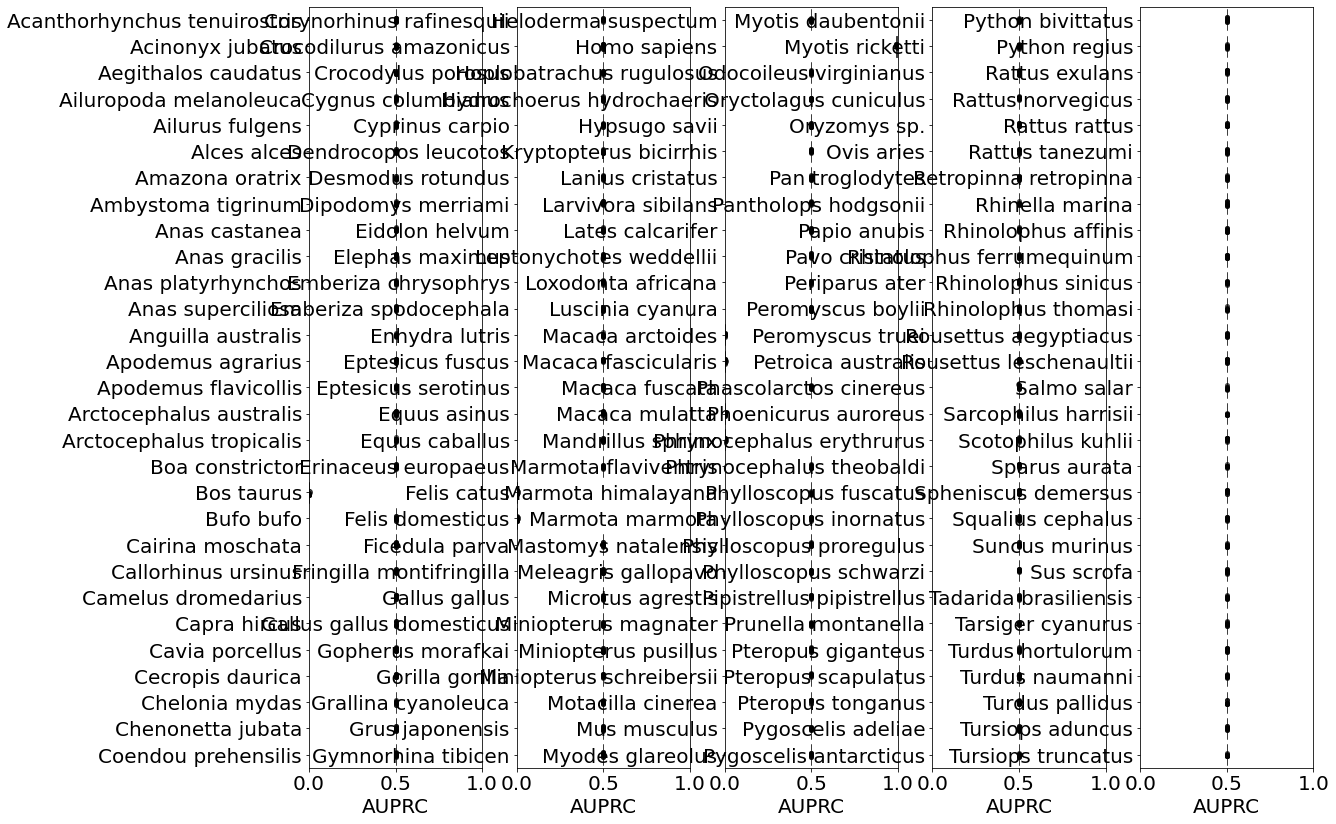

In [26]:
plt.rcParams['figure.autolayout'] = True
plt.clf()
fig, axs = plt.subplots(1, 5, figsize=(18, 14), sharex=True)
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams.update({'font.size': 20})



output_auprc_df.sort_values(by=["class"], key=lambda x: x.map(classes_order), inplace=True)
formatted_df = output_auprc_df.replace({"class": metadata_formatted})
classes = list(formatted_df["class"].unique())
bins = get_uniformly_divided_position_bins(list(classes), 5)
for i in range(5):
    #sns.violinplot(data=formatted_df[formatted_df["class"].isin(bins[i])],  x="auprc", y="class", ax=axs, orient="h",  order=bins[i], fill=False,)
    #sns.barplot(data=formatted_df[formatted_df["class"].isin(bins[i])],  x="auprc", y="class", ax=axs, orient="h", linewidth=3, fill=False, fliersize=2.5, order=bins[i])
    sns.boxplot(data=formatted_df[formatted_df["class"].isin(bins[i])],  x="auprc", y="class", ax=axs[i], orient="h", order=bins[i]) #color="black", alpha=.7, s=5)
    
    sns.stripplot(data=formatted_df[formatted_df["class"].isin(bins[i])], x="auprc", y="class", ax=axs[i], orient="h", color="black", alpha=.7, s=5, order=bins[i])
    #plt.draw()

    axs[i].set_ylabel("")
    axs[i].set_xlabel("AUPRC", fontsize=20)
    axs[i].set_xlim(0, 1)
#     axs.xaxis.set_major_locator(ticker.MultipleLocator(.1))
#     axs.xaxis.set_major_formatter(ticker.ScalarFormatter())

plt.tight_layout(pad=.1)
plt.savefig(os.path.join(os.getcwd(), "..","..", "..", "output/visualization/temp_new/host_multi_fsl_idv_seen_hosts_classwise_auprc_boxplot.pdf"))
plt.show()

### Unseen Hosts

In [6]:
output_df = pd.read_csv(virprobert_unseen_host_output_filepath, index_col=0)
dataset_df = pd.read_csv(dataset_file_path)

In [8]:
output_df

,Acanthorhynchus tenuirostris,Acinonyx jubatus,Aegithalos caudatus,Ailuropoda melanoleuca,Ailurus fulgens,Alces alces,Amazona oratrix,Ambystoma tigrinum,Anas castanea,Anas gracilis,...,Turdus hortulorum,Turdus naumanni,Turdus pallidus,Tursiops aduncus,Tursiops truncatus,Vespertilio sinensis,Vulpes vulpes,Zoothera dauma,y_true,itr
0,0.010520,0.003197,0.000451,0.003493,0.000276,0.000035,0.001103,0.014314,0.007901,0.000141,...,0.000298,0.000239,0.000381,0.000022,0.000768,0.008145,0.000695,0.000078,Cercocebus atys,0
1,0.000022,0.000883,0.002525,0.000360,0.000808,0.000021,0.000529,0.000052,0.008187,0.002739,...,0.000273,0.003799,0.000194,0.000903,0.077941,0.000161,0.014694,0.000246,Cercocebus atys,0
2,0.005028,0.013375,0.001348,0.011306,0.001971,0.000109,0.004423,0.002338,0.006438,0.000212,...,0.001044,0.000721,0.001680,0.000061,0.001649,0.008587,0.002630,0.000434,Cercocebus atys,0
3,0.002281,0.002129,0.000409,0.001502,0.000233,0.000026,0.002881,0.005430,0.002690,0.000266,...,0.000092,0.000111,0.000144,0.000019,0.001147,0.015850,0.000964,0.000060,Cercocebus atys,0
4,0.000468,0.002506,0.000637,0.000802,0.000200,0.000016,0.001981,0.004222,0.003820,0.000732,...,0.000081,0.000213,0.000098,0.000083,0.008510,0.006849,0.002069,0.000084,Cercocebus atys,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2725,0.000290,0.000132,0.018449,0.001120,0.002312,0.000184,0.007653,0.000035,0.009086,0.007053,...,0.001730,0.024313,0.001032,0.000345,0.007527,0.000217,0.008995,0.000151,Puma concolor,0
2726,0.000058,0.001092,0.002623,0.000321,0.001518,0.000221,0.011269,0.000013,0.003245,0.004069,...,0.000367,0.014863,0.000416,0.002344,0.005954,0.000071,0.007927,0.000294,Puma concolor,0
2727,0.000209,0.000069,0.015275,0.000793,0.001043,0.000109,0.003518,0.000029,0.016065,0.010045,...,0.001096,0.019655,0.000661,0.000158,0.013261,0.000104,0.009313,0.000049,Puma concolor,0
2728,0.000114,0.001053,0.003483,0.000549,0.002857,0.000281,0.014361,0.000024,0.006573,0.007675,...,0.000620,0.012501,0.000765,0.002224,0.005427,0.000094,0.011636,0.000484,Puma concolor,0


In [9]:
all_output_labels = list(output_df.columns)
all_output_labels.remove("itr")
all_output_labels.remove("y_true")
print(len(all_output_labels))

167


In [10]:
# Get the label with the maximum probability
output_df["y_pred"] = output_df[all_output_labels].idxmax(axis=1)
output_df["y_pred_prob"] = output_df[all_output_labels].max(axis=1)
output_df

,Acanthorhynchus tenuirostris,Acinonyx jubatus,Aegithalos caudatus,Ailuropoda melanoleuca,Ailurus fulgens,Alces alces,Amazona oratrix,Ambystoma tigrinum,Anas castanea,Anas gracilis,...,Turdus pallidus,Tursiops aduncus,Tursiops truncatus,Vespertilio sinensis,Vulpes vulpes,Zoothera dauma,y_true,itr,y_pred,y_pred_prob
0,0.010520,0.003197,0.000451,0.003493,0.000276,0.000035,0.001103,0.014314,0.007901,0.000141,...,0.000381,0.000022,0.000768,0.008145,0.000695,0.000078,Cercocebus atys,0,Mandrillus leucophaeus,0.111217
1,0.000022,0.000883,0.002525,0.000360,0.000808,0.000021,0.000529,0.000052,0.008187,0.002739,...,0.000194,0.000903,0.077941,0.000161,0.014694,0.000246,Cercocebus atys,0,Cercopithecus neglectus,0.159654
2,0.005028,0.013375,0.001348,0.011306,0.001971,0.000109,0.004423,0.002338,0.006438,0.000212,...,0.001680,0.000061,0.001649,0.008587,0.002630,0.000434,Cercocebus atys,0,Mandrillus leucophaeus,0.048639
3,0.002281,0.002129,0.000409,0.001502,0.000233,0.000026,0.002881,0.005430,0.002690,0.000266,...,0.000144,0.000019,0.001147,0.015850,0.000964,0.000060,Cercocebus atys,0,Macaca arctoides,0.135541
4,0.000468,0.002506,0.000637,0.000802,0.000200,0.000016,0.001981,0.004222,0.003820,0.000732,...,0.000098,0.000083,0.008510,0.006849,0.002069,0.000084,Cercocebus atys,0,Homo sapiens,0.076861
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2725,0.000290,0.000132,0.018449,0.001120,0.002312,0.000184,0.007653,0.000035,0.009086,0.007053,...,0.001032,0.000345,0.007527,0.000217,0.008995,0.000151,Puma concolor,0,Fringilla montifringilla,0.054453
2726,0.000058,0.001092,0.002623,0.000321,0.001518,0.000221,0.011269,0.000013,0.003245,0.004069,...,0.000416,0.002344,0.005954,0.000071,0.007927,0.000294,Puma concolor,0,Puma concolor,0.112320
2727,0.000209,0.000069,0.015275,0.000793,0.001043,0.000109,0.003518,0.000029,0.016065,0.010045,...,0.000661,0.000158,0.013261,0.000104,0.009313,0.000049,Puma concolor,0,Chlorocebus sabaeus,0.100384
2728,0.000114,0.001053,0.003483,0.000549,0.002857,0.000281,0.014361,0.000024,0.006573,0.007675,...,0.000765,0.002224,0.005427,0.000094,0.011636,0.000484,Puma concolor,0,Rattus tanezumi,0.056421


In [12]:
dataset_df["virus_host_name"].nunique()

32

In [14]:
labels_present_in_output = set(metadata_unformatted.keys()).intersection(set(all_output_labels))
print(len(labels_present_in_output))
labels_present_in_output

19


{'Cercocebus atys',
 'Cercocebus torquatus',
 'Cercopithecus aethiops',
 'Cercopithecus cephus',
 'Cercopithecus lhoesti',
 'Cercopithecus mitis',
 'Cercopithecus mona',
 'Cercopithecus neglectus',
 'Cercopithecus nictitans',
 'Cercopithecus solatus',
 'Chlorocebus pygerythrus',
 'Chlorocebus sabaeus',
 'Chlorocebus tantalus',
 'Colobus guereza',
 'Felis silvestris catus',
 'Macaca nemestrina',
 'Mandrillus leucophaeus',
 'Panthera leo',
 'Puma concolor'}

In [15]:
# compute_metrics
metrics = []
for label in labels_present_in_output:
    precision = precision_score(y_true = output_df["y_true"].values, y_pred = output_df["y_pred"].values, labels=[label], average=None)
    metrics.append({
        "class": label,
        "precision": precision[0]
    })

metrics_df = pd.DataFrame(metrics)
metrics_df

/home/blessyantony/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,class,precision
0,Cercopithecus cephus,0.000000
1,Cercopithecus lhoesti,0.000000
2,Puma concolor,0.444444
3,Chlorocebus sabaeus,0.431818
4,Colobus guereza,0.000000
5,Mandrillus leucophaeus,0.152941
6,Cercopithecus mitis,0.000000
7,Cercopithecus aethiops,0.000000
8,Cercocebus torquatus,0.000000
9,Macaca nemestrina,0.461538


In [16]:
metrics_df["class"].nunique()

19

In [17]:
metrics_df["prevalence"] = metrics_df["class"].apply(lambda x: metadata_unformatted[x])
metrics_df

,class,precision,prevalence
0,Cercopithecus cephus,0.000000,0.005907
1,Cercopithecus lhoesti,0.000000,0.003635
2,Puma concolor,0.444444,0.010906
3,Chlorocebus sabaeus,0.431818,0.005907
4,Colobus guereza,0.000000,0.005907
5,Mandrillus leucophaeus,0.152941,0.009088
6,Cercopithecus mitis,0.000000,0.002726
7,Cercopithecus aethiops,0.000000,0.006362
8,Cercocebus torquatus,0.000000,0.007270
9,Macaca nemestrina,0.461538,0.010451


<Figure size 432x288 with 0 Axes>

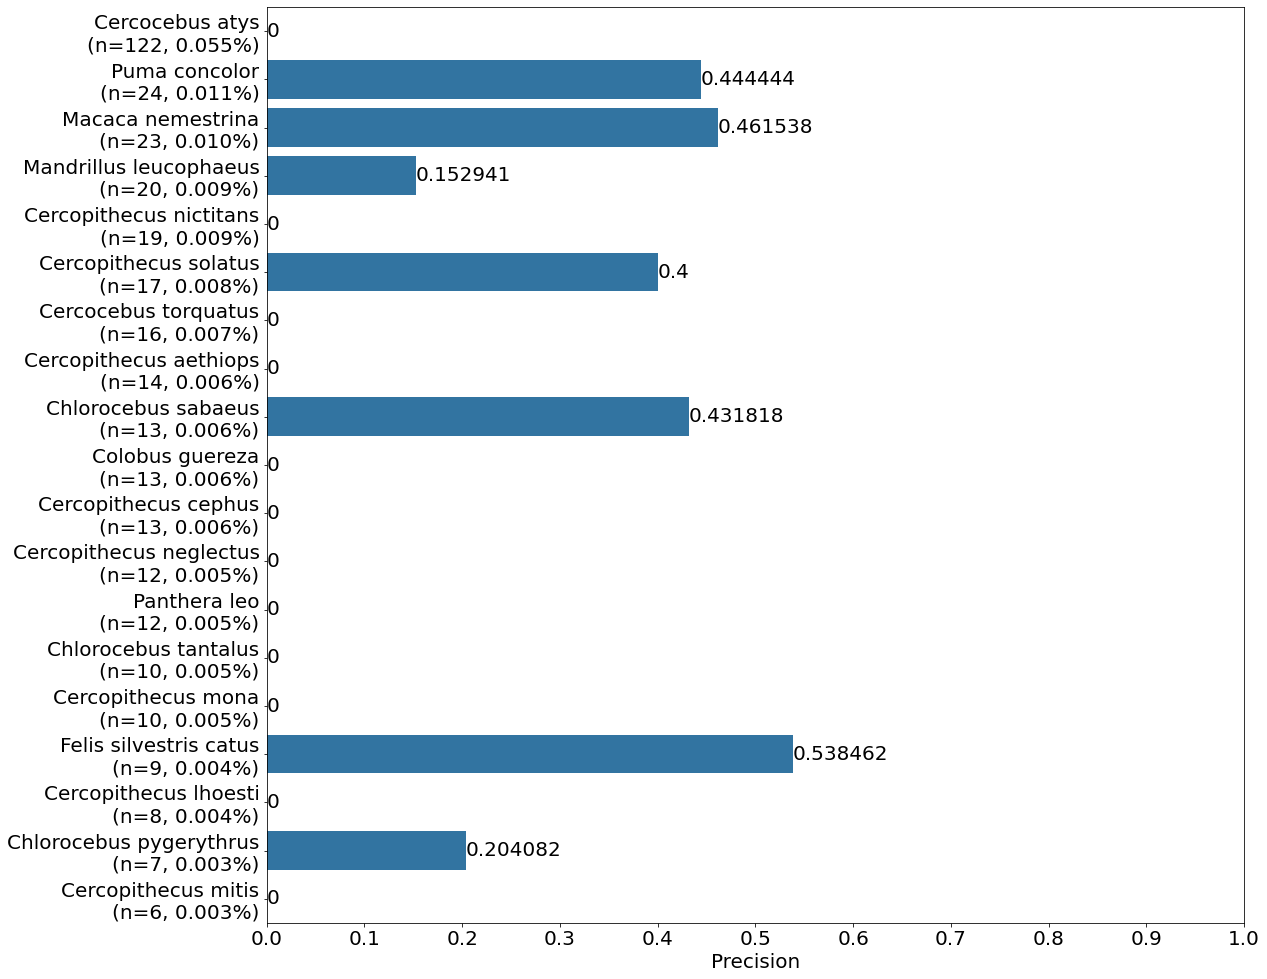

In [22]:
plt.rcParams['figure.autolayout'] = True
plt.clf()
fig, axs = plt.subplots(1, 1, figsize=(18, 14), sharex=True)
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams.update({'font.size': 20})



metrics_df.sort_values(by=["class"], key=lambda x: x.map(classes_order), inplace=True)
formatted_df = metrics_df.replace({"class": metadata_formatted})
classes = list(formatted_df["class"].unique())
bins = get_uniformly_divided_position_bins(list(classes), 1)
for i in range(1):
    #sns.violinplot(data=formatted_df[formatted_df["class"].isin(bins[i])],  x="auprc", y="class", ax=axs, orient="h",  order=bins[i], fill=False,)
    #sns.barplot(data=formatted_df[formatted_df["class"].isin(bins[i])],  x="auprc", y="class", ax=axs, orient="h", linewidth=3, fill=False, fliersize=2.5, order=bins[i])
    sns.barplot(data=formatted_df[formatted_df["class"].isin(bins[i])],  x="precision", y="class", ax=axs, orient="h", order=bins[i]) #color="black", alpha=.7, s=5)
    axs.bar_label(axs.containers[0], fontsize=20);
    #sns.stripplot(data=formatted_df[formatted_df["class"].isin(bins[i])], x="auprc", y="class", ax=axs[i], orient="h", color="black", order=bins[i])
    #plt.draw()

    axs.set_ylabel("")
    axs.set_xlabel("Precision", fontsize=20)
    axs.set_xlim(0, 1)
    axs.xaxis.set_major_locator(ticker.MultipleLocator(.1))
    axs.xaxis.set_major_formatter(ticker.ScalarFormatter())

plt.tight_layout(pad=.1)
plt.savefig(os.path.join(os.getcwd(), "..","..", "..", "output/visualization/temp_new/host_multi_fsl_idv_w_non_idv_wo_human_classwise_boxplot.pdf"))
plt.show()

<Figure size 432x288 with 0 Axes>

<Figure size 576x576 with 0 Axes>

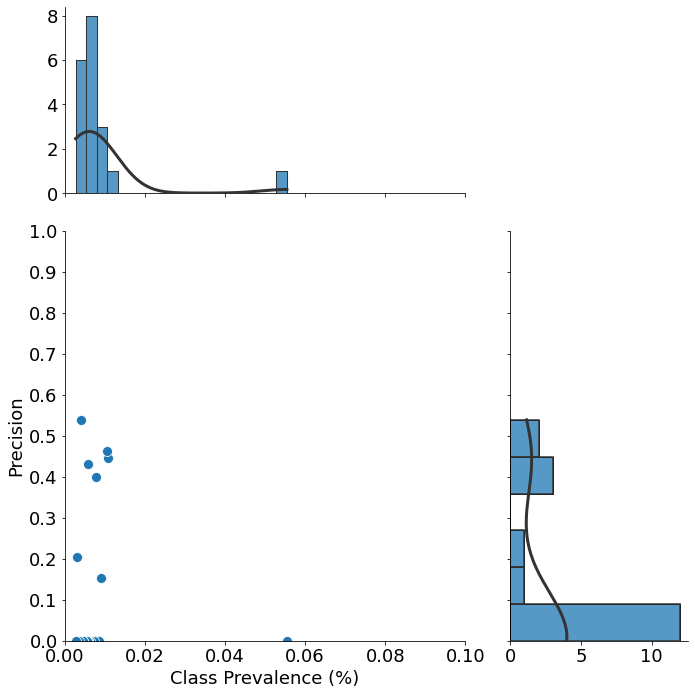

In [25]:
plt.clf()
plt.figure(figsize=(8,8))
plt.rcParams["figure.autolayout"] = True
plt.rcParams["xtick.labelsize"] = 18
plt.rcParams["ytick.labelsize"] = 18
plt.rcParams.update({'font.size': 18})

ax = sns.jointplot(data=formatted_df, x="prevalence", y="precision",
                   height=10, ylim=(0, 1),  xlim=(0, .1),
                   ratio=2, legend=False, marginal_ticks=True)
ax.plot_joint(sns.scatterplot, alpha=1, s=100, legend=False)
ax.plot_marginals(sns.histplot, kde=True, fill=False, color="0.2", line_kws={"color": "black", "lw": 3, "ls": "-"})
# ax = sns.scatterplot(mean_auprc_df, x="prevalance", y="auprc", hue="model", alpha=1)
ax.ax_joint.set_xlabel("Class Prevalence (%)")
ax.ax_joint.set_ylabel("Precision")
ax.ax_joint.xaxis.set_major_locator(ticker.MultipleLocator(.02))
ax.ax_joint.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.ax_joint.yaxis.set_major_locator(ticker.MultipleLocator(.1))
ax.ax_joint.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax = plt.gca()
#ax.legend()
ax.figure.tight_layout()
plt.savefig(os.path.join(os.getcwd(), "..","..", "..", "output/visualization/temp_new/host_multi_fsl_idv_precision_scatterplot_w_hist.pdf"))
plt.show()